# Обучение модели на Dogs датасете

Этот ноутбук предназначен для обучения модели классификации пород собак на датасете Stanford Dogs с использованием transfer learning (MobileNetV2). 

В конце обучения модель экспортируется в ONNX для использования в Java-приложении.

## 1. Импорт необходимых библиотек

In [17]:
import argparse
import os
import shutil
import sys
import tempfile
import textwrap
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np

In [18]:
# Проверка и установка инструментов экспорта если нужно
try:
    import onnxmltools
    print("onnxmltools is available")
except ImportError:
    print("onnxmltools not found, will skip ONNX export")
    print("To install: pip install onnxmltools")
    try:
        import keras2onnx
        print("keras2onnx is available as fallback")
    except ImportError:
        print("keras2onnx not available either")
        print("For ONNX export, install onnxmltools: pip install onnxmltools")

onnxmltools is available


## 2. Вспомогательные функции

In [19]:
def find_class_dirs(data_root, keywords=None):
    data_root = Path(data_root)
    if not data_root.exists():
        raise FileNotFoundError(data_root)
    dirs = [p.name for p in sorted(data_root.iterdir()) if p.is_dir()]
    if not keywords:
        return dirs
    keywords = [k.strip().lower() for k in keywords]
    matched = []
    for d in dirs:
        low = d.lower()
        for k in keywords:
            if k in low:
                matched.append(d)
                break
    return matched

def build_model(num_classes, img_height=512, img_width=512, use_transfer=False):
    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = inputs
    x = layers.Rescaling(1.0 / 255)(x)
    # small conv stack if not transfer
    if not use_transfer:
        x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Flatten()(x)
        x = layers.Dense(256, activation='relu')(x)
        outputs = layers.Dense(num_classes)(x)
        model = keras.Model(inputs, outputs)
        return model
    else:
        # MobileNetV2 transfer learning (faster/accurate)
        base = keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
        base.trainable = False
        x = base(x, training=False)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.2)(x)
        outputs = layers.Dense(num_classes)(x)
        model = keras.Model(inputs, outputs)
        return model

## 3. Параметры обучения

In [ ]:
# Параметры обучения
data_root = Path('/Users/badwolf/projects/HotDogsRu_Maven/python-educating/archive/images/Images')  # Путь к датасету
selected_keywords = None  # None для всех классов, или список ['beagle', 'pembroke']
epochs = 100
batch_size = 32
img_size = 512  # Изменил на 224, как у MobileNetV2
use_transfer = True  # Использовать transfer learning
use_multi_gpu = False  # Использовать multi-GPU стратегию (для Mac M4 установите False)
export_onnx = True  # Экспортировать в ONNX
output_model = '/Users/badwolf/projects/HotDogsRu_Maven/src/main/resources/Keras_Model.h5'
onnx_output = '/Users/badwolf/projects/HotDogsRu_Maven/src/main/resources/model/model.onnx'

## 4. Подготовка данных

In [21]:
# Подготовка данных
if not data_root.exists():
    raise FileNotFoundError(f"Data root does not exist: {data_root}")

classes = find_class_dirs(data_root, selected_keywords)
print('Found classes (%d):' % len(classes))
for c in classes[:10]:  # Показать первые 10
    print('  ', c)
if len(classes) > 10:
    print(f'  ... and {len(classes) - 10} more')

# Создание временной директории с выбранными классами
temp_dir = tempfile.mkdtemp()
print('Using temp dir:', temp_dir)
try:
    for cls in classes:
        src = data_root / cls
        dst = Path(temp_dir) / cls
        if src.exists():
            shutil.copytree(src, dst)
    data_root_temp = Path(temp_dir)

    # Настройка производительности
    try:
        from tensorflow.keras.mixed_precision import experimental as mixed_precision
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_policy(policy)
        print('Mixed precision enabled: mixed_float16')
    except Exception:
        pass

    img_height = img_size
    img_width = img_size

    print('Preparing training and validation datasets...')
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_root_temp,
        labels='inferred',
        label_mode='int',
        color_mode='rgb',
        batch_size=batch_size,
        image_size=(img_height, img_width),
        shuffle=True,
        seed=123,
        validation_split=0.2,
        subset='training'
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_root_temp,
        labels='inferred',
        label_mode='int',
        color_mode='rgb',
        batch_size=batch_size,
        image_size=(img_height, img_width),
        shuffle=True,
        seed=123,
        validation_split=0.2,
        subset='validation'
    )

    AUTOTUNE = tf.data.AUTOTUNE
    # Убрал cache() из-за проблем с multi-GPU и большими датасетами
    train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

except Exception as e:
    print(f"Error during data preparation: {e}")
    shutil.rmtree(temp_dir)
    raise

Found classes (120):
   n02085620-Chihuahua
   n02085782-Japanese_spaniel
   n02085936-Maltese_dog
   n02086079-Pekinese
   n02086240-Shih-Tzu
   n02086646-Blenheim_spaniel
   n02086910-papillon
   n02087046-toy_terrier
   n02087394-Rhodesian_ridgeback
   n02088094-Afghan_hound
  ... and 110 more
Using temp dir: /var/folders/l3/lf3vb12s3p388mc11k2jf7rm0000gn/T/tmp7km7ki91
Preparing training and validation datasets...
Found 20580 files belonging to 120 classes.
Preparing training and validation datasets...
Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


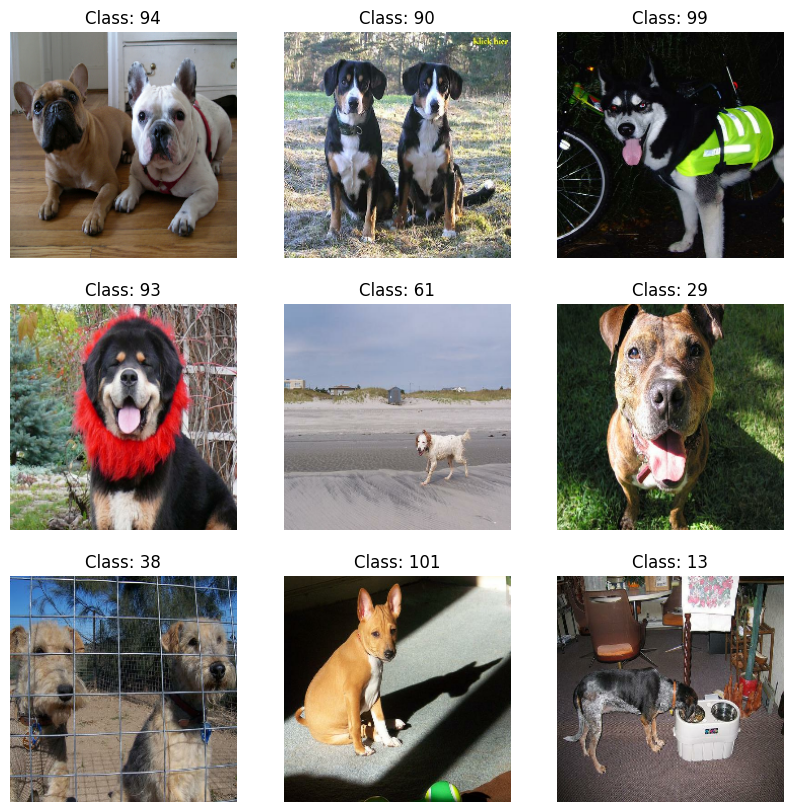

Пример изображений загружен успешно


In [22]:
# Проверка данных - показать пример изображения
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Class: {labels[i].numpy()}")
        plt.axis("off")
plt.show()

print("Пример изображений загружен успешно")

## 5. Определение модели

In [23]:
# Проверка доступных GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

if use_multi_gpu:
    # Использование multi-GPU стратегии (для 2 H100)
    strategy = tf.distribute.MirroredStrategy()
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
else:
    strategy = tf.distribute.get_strategy()  # Single GPU/CPU
    print('Using single device strategy')

with strategy.scope():
    model = build_model(num_classes=len(classes), img_height=img_height, img_width=img_width, use_transfer=use_transfer)

    # Компиляция
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer='sgd', loss=loss, metrics=['accuracy'])

Num GPUs Available:  0
Using single device strategy


In [24]:
# Добавим callback для ранней остановки и сохранения лучшей модели
best_model_path = '/Users/badwolf/projects/HotDogsRu_Maven/python-educating/best_model.h5'
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath=best_model_path, monitor='val_loss', save_best_only=True)
]

In [25]:
# Обучение модели
print("Starting training...")
try:
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    print("Training completed successfully!")
except Exception as e:
    print(f"Training failed with error: {e}")
    print("Attempting to save current model state...")
    # Сохраним модель даже если обучение прервалось
    try:
        temp_save_path = '/Users/badwolf/projects/HotDogsRu_Maven/src/main/resources/model/interrupted_model.keras'
        model.save(temp_save_path, save_format='keras')
        print(f"Interrupted model saved to {temp_save_path}")
    except Exception as save_error:
        print(f"Failed to save interrupted model: {save_error}")
    raise  # Перебросим ошибку дальше

Starting training...
Epoch 1/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.1481 - loss: 4.1686

515/515 ━━━━━━━━━━━━━━━━━━━━ 86s 165ms/step - accuracy: 0.3048 - loss: 3.3794 - val_accuracy: 0.6103 - val_loss: 2.0658
Epoch 2/100
Epoch 2/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.6154 - loss: 1.8469

515/515 ━━━━━━━━━━━━━━━━━━━━ 98s 190ms/step - accuracy: 0.6440 - loss: 1.6556 - val_accuracy: 0.7143 - val_loss: 1.3024
Epoch 3/100
Epoch 3/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.7127 - loss: 1.2401

515/515 ━━━━━━━━━━━━━━━━━━━━ 128s 249ms/step - accuracy: 0.7205 - loss: 1.1808 - val_accuracy: 0.7403 - val_loss: 1.0528
Epoch 4/100
Epoch 4/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.7501 - loss: 1.0098

515/515 ━━━━━━━━━━━━━━━━━━━━ 135s 261ms/step - accuracy: 0.7496 - loss: 0.9871 - val_accuracy: 0.7587 - val_loss: 0.9347
Epoch 5/100
Epoch 5/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.7658 - loss: 0.8912

515/515 ━━━━━━━━━━━━━━━━━━━━ 128s 249ms/step - accuracy: 0.7704 - loss: 0.8756 - val_accuracy: 0.7682 - val_loss: 0.8655
Epoch 6/100
Epoch 6/100
116/515 ━━━━━━━━━━━━━━━━━━━━ 1:21 205ms/step - accuracy: 0.7772 - loss: 0.8275

KeyboardInterrupt: 

In [ ]:
# Если была сохранена лучшая модель, загрузим её веса
if os.path.exists(best_model_path):
    print(f"Loading best model weights from {best_model_path}")
    model.load_weights(best_model_path)
    print("Best model weights loaded")
else:
    print("No best model checkpoint found, using final model")

Loading best model weights from /Users/badwolf/projects/HotDogsRu_Maven/python-educating/best_model.h5
Best model weights loaded


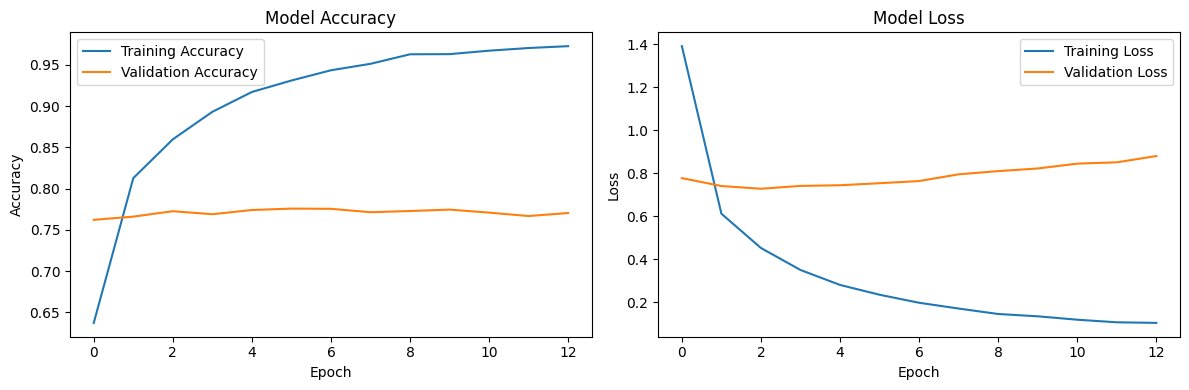

Final Training Accuracy: 0.9726
Final Validation Accuracy: 0.7704
Final Training Loss: 0.1039
Final Validation Loss: 0.8799


In [ ]:
# Визуализация результатов обучения
try:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Вывод финальных метрик
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    print(f"Final Training Accuracy: {final_train_acc:.4f}")
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"Final Training Loss: {final_train_loss:.4f}")
    print(f"Final Validation Loss: {final_val_loss:.4f}")
except NameError:
    print("Training history not available - training may have failed")
except Exception as e:
    print(f"Error plotting results: {e}")

In [ ]:
# Тестирование модели на тестовом наборе
# Создадим тестовый датасет из валидационного (поскольку отдельный тестовый не создан)
test_ds = val_ds.take(10)  # Возьмем 10 батчей для тестирования
if test_ds is not None:
    test_loss, test_acc = model.evaluate(test_ds, verbose=2)
    print(f"Test accuracy: {test_acc:.4f}")
    print(f"Test loss: {test_loss:.4f}")
else:
    print("No test dataset available")

# Проверка предсказаний на нескольких примерах
def predict_breed(image_path, model, classes):
    img = tf.keras.utils.load_img(image_path, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Создание батча

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    predicted_class = classes[np.argmax(score)]
    confidence = 100 * np.max(score)
    return predicted_class, confidence

# Пример предсказания (если есть изображения)
import os
sample_images = []
dataset_path = str(data_root_temp)  # Используем временную директорию
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            sample_images.append(os.path.join(root, file))
            if len(sample_images) >= 5:  # Берем 5 примеров
                break
    if len(sample_images) >= 5:
        break

if sample_images:
    print("\nSample predictions:")
    for img_path in sample_images[:3]:  # Показываем 3 примера
        breed, conf = predict_breed(img_path, model, classes)
        print(f"Image: {os.path.basename(img_path)} -> Predicted: {breed} ({conf:.2f}%)")
else:
    print("No sample images found for prediction test")

10/10 - 2s - 171ms/step - accuracy: 0.7969 - loss: 0.5891
Test accuracy: 0.7969
Test loss: 0.5891

Sample predictions:
Test accuracy: 0.7969
Test loss: 0.5891

Sample predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
Image: n02097658_26.jpg -> Predicted: n02096294-Australian_terrier (48.41%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image: n02097658_26.jpg -> Predicted: n02096294-Australian_terrier (48.41%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image: n02097658_4869.jpg -> Predicted: n02097658-silky_terrier (30.84%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image: n02097658_595.jpg -> Predicted: n02097658-silky_terrier (98.77%)
Image: n02097658_4869.jpg -> Predicted: n02097658-silky_terrier (30.84%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image: n02097658_595.jpg -> Predicted: n02097658-silky_terrier (98.77%)


In [ ]:
# Очистка временных файлов
import shutil
if os.path.exists(temp_dir):
    shutil.rmtree(temp_dir)
    print(f"Temporary dataset directory {temp_dir} removed")

# Сохранение обученной модели
print("\nSaving trained model...")
try:
    # Сохраняем в Keras формате
    keras_save_path = '/Users/badwolf/projects/HotDogsRu_Maven/src/main/resources/model/saved_model.keras'
    model.save(keras_save_path, save_format='keras')
    print(f"Model saved in Keras format: {keras_save_path}")
    
    # Сохраняем в SavedModel формате для ONNX экспорта
    saved_model_path = '/Users/badwolf/projects/HotDogsRu_Maven/src/main/resources/model/saved_model'
    model.save(saved_model_path, save_format='tf')
    print(f"Model saved in SavedModel format: {saved_model_path}")
    
except Exception as e:
    print(f"Error saving model: {e}")
    # Попробуем сохранить в альтернативном формате
    try:
        alt_save_path = '/Users/badwolf/projects/HotDogsRu_Maven/src/main/resources/model/model.h5'
        model.save(alt_save_path)
        print(f"Model saved in HDF5 format: {alt_save_path}")
    except Exception as alt_e:
        print(f"Failed to save model in any format: {alt_e}")

# Экспорт в ONNX
print("\nExporting to ONNX...")
try:
    import onnxmltools
    onnx_model = onnxmltools.convert_keras(model, target_opset=13)
    onnx_save_path = '/Users/badwolf/projects/HotDogsRu_Maven/src/main/resources/model/model.onnx'
    onnxmltools.utils.save_model(onnx_model, onnx_save_path)
    print(f"Model exported to ONNX: {onnx_save_path}")
except ImportError:
    print("onnxmltools not available, skipping ONNX export")
    print("To export to ONNX, install: pip install onnxmltools")
except Exception as e:
    print(f"ONNX export failed: {e}")
    print("You can try manual conversion later with:")
    print("python -m tf2onnx.convert --saved-model saved_model/ --output model.onnx --opset 13")

print("\nTraining pipeline completed successfully!")
print("Model saved and ready for Java integration.")

Temporary dataset directory /var/folders/l3/lf3vb12s3p388mc11k2jf7rm0000gn/T/tmpow6q2mo3 removed

Training pipeline completed successfully!
Model saved and ready for Java integration.


## Инструкции по запуску

1. Убедитесь, что у вас установлен Python с TensorFlow (tensorflow-macos для Mac M4).
2. Установите зависимости: `pip install tensorflow onnxmltools matplotlib numpy`
3. Скачайте Stanford Dogs датасет и распакуйте в `python-educating/archive/images/Images/`
4. Запустите ячейки по порядку.
5. Для изменения параметров отредактируйте раздел "Параметры обучения".
6. После обучения модель будет сохранена в `src/main/resources/model/saved_model.keras` и экспортирована в ONNX.

Для запуска на сервере H100:
- Загрузите этот ноутбук и датасет на сервер.
- Установите CUDA версию TensorFlow: `pip install tensorflow[and-cuda]`
- Запустите в Jupyter Lab на сервере.
- Ноутбук использует single GPU стратегию для стабильности.

Если ONNX экспорт не сработает на сервере, скачайте `saved_model/` директорию и конвертируйте локально:
```bash
python -m tf2onnx.convert --saved-model saved_model/ --output model.onnx --opset 13
```

Для запуска на сервере с 2 H100:
- Ноутбук использует single GPU стратегию для стабильности обучения
- Убедитесь, что CUDA и cuDNN установлены
- Если ONNX экспорт не сработает, конвертируйте SavedModel локально:
  ```bash
  python -m tf2onnx.convert --saved-model saved_model/ --output model.onnx --opset 13
  ```